In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from reduce_memory import reduce_mem_usage

In [2]:
transactions = pd.read_csv('../data/raw/train_transaction.csv')
transactions = reduce_mem_usage(transactions)

Mem. usage decreased to 916.30 Mb (48.4% reduction)


In [3]:
print(transactions.shape)

(590540, 394)


## Columns

In [4]:
# Transaction columns: TransactionID, TransactionDT, TransactionAmt
# Product columns: ProductCD
# Cards: 6 columns
# Addresses: 2 columns
# Dist?
# Email: 2 columns
# C variables: 14 columns
# D variables: 15 columns
# M variables: 9 columns
# V variables: 339 columns

In [5]:
transactions.dtypes

TransactionID       int32
isFraud              int8
TransactionDT       int32
TransactionAmt    float32
ProductCD             str
                   ...   
V335              float32
V336              float32
V337              float32
V338              float32
V339              float32
Length: 394, dtype: object

In [6]:
transactions.isnull().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
V335              508189
V336              508189
V337              508189
V338              508189
V339              508189
Length: 394, dtype: int64

## Time

In [7]:
transactions['hour'] = (transactions['TransactionDT'] // 3600) % 24
transactions['day'] = (transactions['TransactionDT'] // (3600 * 24)) % 7

/tmp/ipykernel_5994/1584168985.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transactions['hour'] = (transactions['TransactionDT'] // 3600) % 24
/tmp/ipykernel_5994/1584168985.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transactions['day'] = (transactions['TransactionDT'] // (3600 * 24)) % 7


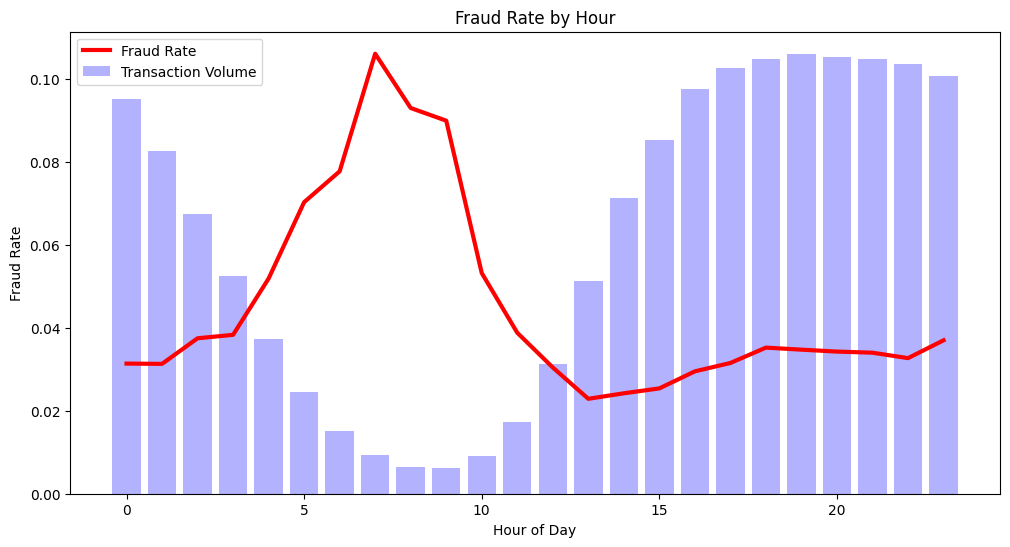

In [8]:
# Fraud rate per hour
# The graph shows a spike between hours 3-13
# This suggests that fraudsters operate in different time zones when users are asleep
# Or that the fraud is automated to occur during nocturnal hours
plt.figure(figsize=(12, 6))

hourly_fraud = transactions.groupby('hour')['isFraud'].mean()
hourly_vol = transactions.groupby('hour')['TransactionID'].count() / transactions.groupby('hour')['TransactionID'].count().max()

plt.plot(hourly_fraud.index, hourly_fraud.values, label='Fraud Rate', color='red', linewidth=3)
plt.bar(hourly_vol.index, hourly_vol.values * hourly_fraud.max(), alpha=0.3, label='Transaction Volume', color='blue')
plt.title('Fraud Rate by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate')
plt.legend()
plt.show()

/tmp/ipykernel_5994/1924549299.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=email_risk.index, y=email_risk.values, palette='Reds_r')


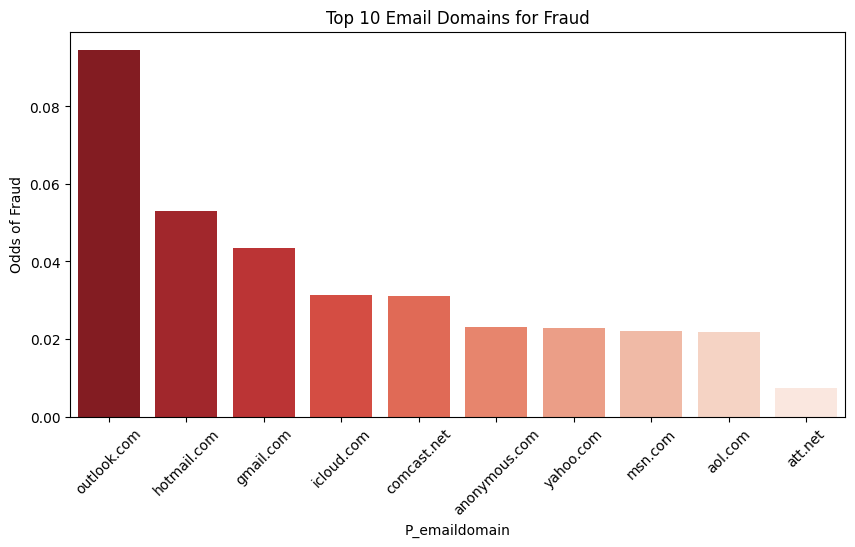

In [9]:
# Email domain fraud
# Not surprising to see Outlook first since it's so common in the professional environments
# Hotmail and Gmail are most probably the common domains for personal emails
top_emails = transactions['P_emaildomain'].value_counts().head(10).index
email_risk = transactions[transactions['P_emaildomain'].isin(top_emails)].groupby('P_emaildomain')['isFraud'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=email_risk.index, y=email_risk.values, palette='Reds_r')
plt.title('Top 10 Email Domains for Fraud')
plt.ylabel('Odds of Fraud')
plt.xticks(rotation=45)
plt.show()

## Cards

In [10]:
card_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
df_cards = transactions[card_cols]
df_cards.head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


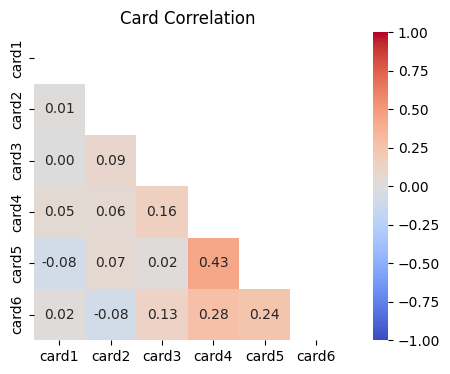

In [11]:
# Label encoding text values
for col in ['card4', 'card6']:
    df_cards[col] = df_cards[col].astype('category').cat.codes

# All missing values will be -1
df_cards = df_cards.fillna(-1)

# No high correlations here, we are good.
corr_matrix = df_cards.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(8,4))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title('Card Correlation')
plt.show()

## Product

In [12]:
# Product W has the lowest fraud rate but the highest fraud count and second-highest amount
# C has highest fraud rate and second-highest count
# R has highest avg amount

product_summary = transactions.groupby('ProductCD').agg({
    'isFraud': ['mean', 'count'],
    'TransactionAmt': 'mean'
}).sort_values(('isFraud', 'count'), ascending = False)

product_summary.columns = ['Fraud Rate', 'Count', 'Avg Amount']
print(product_summary)

           Fraud Rate   Count  Avg Amount
ProductCD                                
W            0.020399  439670  153.158554
C            0.116873   68519   42.872353
R            0.037826   37699  168.306183
H            0.047662   33024   73.170059
S            0.058996   11628   60.269489


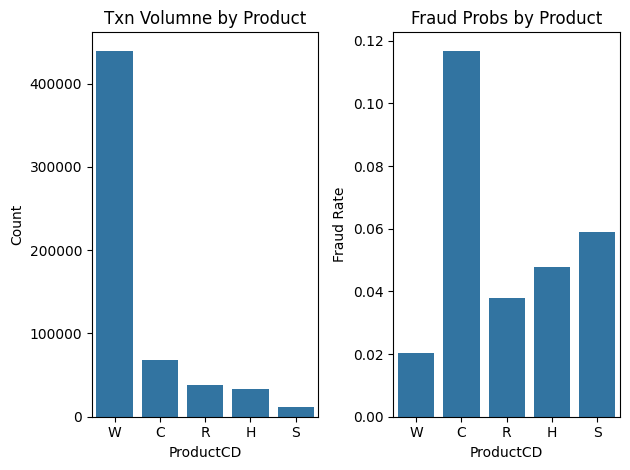

In [13]:
# W highest volume, C highest odds of fraud
# How to evaulate this in a cost function?
# i.e. is it more financially worthwhile to minimize fraud in W or in C? How do the other products fit in here?

plt.subplot(1, 2, 1)
sns.countplot(x = 'ProductCD', data=transactions, order=product_summary.index)
plt.title('Txn Volumne by Product')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.barplot(x=product_summary.index, y=product_summary['Fraud Rate'])
plt.title('Fraud Probs by Product')
plt.ylabel('Fraud Rate')

plt.tight_layout()
plt.show()

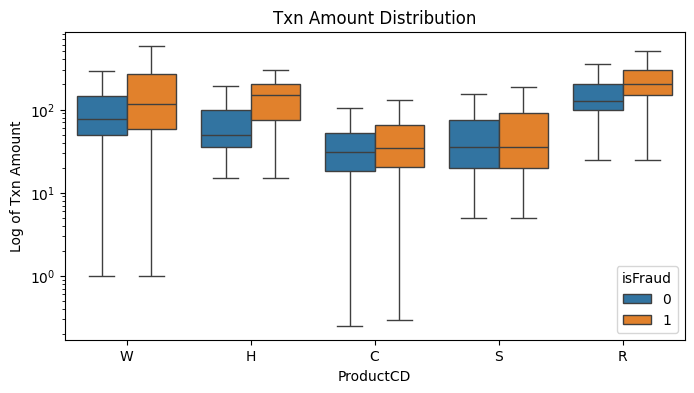

In [14]:
# Txn amount for fraud is always marginally higher than legitimate txns.

plt.figure(figsize=(8,4))
sns.boxplot(x='ProductCD', y='TransactionAmt', hue='isFraud', data=transactions, showfliers=False)
plt.title('Txn Amount Distribution')
plt.yscale('log')
plt.ylabel('Log of Txn Amount')
plt.show()

In [15]:
# Calculating economic impact of W vs C
# Two-thirds of total fraud happens in product W
# W, C and R represent more than 90% of all fraud
# This can allow us to follow the Pareto Principle which minimizes fraud on these three products (unless we find better options for creating a model)
 
economic_impact = transactions.groupby('ProductCD').apply(
    lambda x: pd.Series({
        'Fraud_Rate': x['isFraud'].mean(),
        'Avg_Fraud_Amt': x[x['isFraud'] == 1]['TransactionAmt'].mean(),
        'Total_Fraud_Loss': x[x['isFraud'] == 1]['TransactionAmt'].sum(),
        'Percent_of_Total_Loss': x[x['isFraud'] == 1]['TransactionAmt'].sum() / transactions[transactions['isFraud'] == 1]['TransactionAmt'].sum()
    })
).sort_values('Total_Fraud_Loss', ascending=False)

economic_impact

,Fraud_Rate,Avg_Fraud_Amt,Total_Fraud_Loss,Percent_of_Total_Loss
ProductCD,,,,
W,0.020399,229.047318,2.054325e+06,0.666157
C,0.116873,48.878796,3.914214e+05,0.126926
R,0.037826,244.074341,3.480500e+05,0.112862
H,0.047662,156.691238,2.466320e+05,0.079975
S,0.058996,63.288631,4.341600e+04,0.014079


## Location

/tmp/ipykernel_5994/3605077803.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=high_risk_neighbourhoods['addr1'].astype(str), y=high_risk_neighbourhoods['Fraud_Rate'], palette='Reds_r')


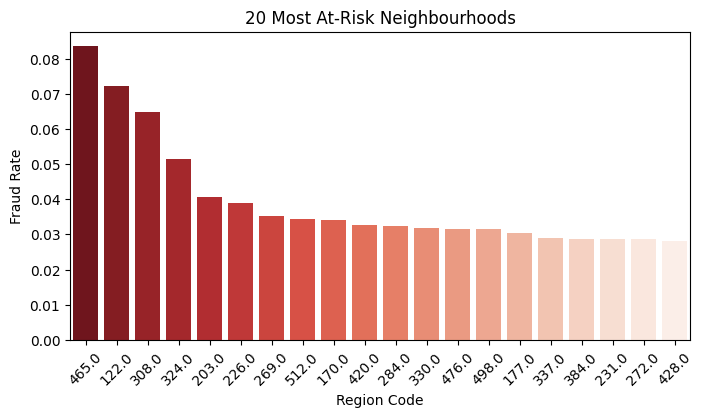

In [16]:
# Finding at-risk neighbourhoods

addr1_summary = transactions.groupby('addr1').agg({
    'isFraud': ['mean', 'count']
}).reset_index()

addr1_summary.columns = ['addr1', 'Fraud_Rate', 'Count']

high_risk_neighbourhoods = addr1_summary[addr1_summary['Count'] > 500].sort_values('Fraud_Rate', ascending = False).head(20)

plt.figure(figsize=(8,4))
sns.barplot(x=high_risk_neighbourhoods['addr1'].astype(str), y=high_risk_neighbourhoods['Fraud_Rate'], palette='Reds_r')
plt.title('20 Most At-Risk Neighbourhoods')
plt.xlabel('Region Code')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.show()

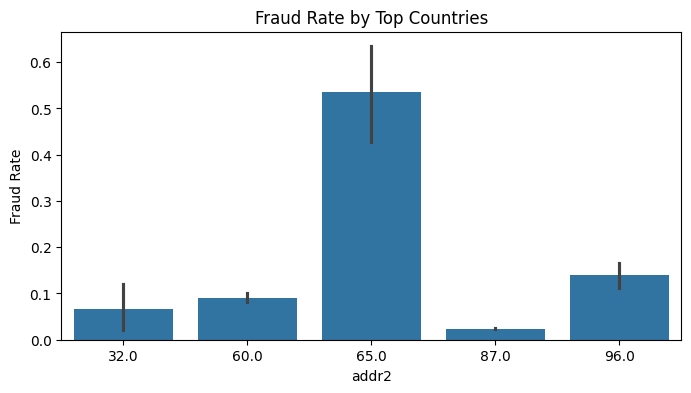

US Code:  87.0
non_US
0    0.023972
1    0.116844
Name: isFraud, dtype: float64


/tmp/ipykernel_5994/4027461508.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transactions['non_US'] = (transactions['addr2'] != us_code).astype(int)


In [17]:
# addr 2 seems to be country codes, mostly 87 (US)
# Let's see if we can detect US vs non-US fraud rates

top_countries = transactions['addr2'].value_counts().head(5).index
plt.figure(figsize=(8,4))
sns.barplot(x='addr2', y='isFraud', data=transactions[transactions['addr2'].isin(top_countries)])
plt.title('Fraud Rate by Top Countries')
plt.ylabel('Fraud Rate')
plt.show()

us_code = transactions['addr2'].mode()[0]
transactions['non_US'] = (transactions['addr2'] != us_code).astype(int)

# Fraud rate outside of US for addr2 is 5 times higher than domestic
print('US Code: ', us_code)
print(transactions.groupby('non_US')['isFraud'].mean())

## Distance

/tmp/ipykernel_5994/2446959230.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transactions['dist1_missing'] = transactions['dist1'].isnull().astype(int)


dist1_missing
0    0.019956
1    0.045158
Name: isFraud, dtype: float64


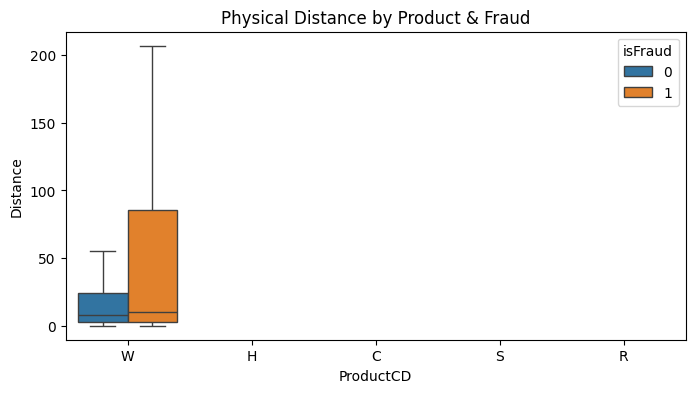

In [18]:
# Mapping if distance is known or not
# Ignoring dist2 since it's mostly empty and not useful for training a model

transactions['dist1_missing'] = transactions['dist1'].isnull().astype(int)

print(transactions.groupby('dist1_missing')['isFraud'].mean())

# Mapping this
# Fraudsters are mostly physically farther from home address of legitimate owner of card

plt.figure(figsize=(8,4))
sns.boxplot(x='ProductCD', y='dist1', hue='isFraud', data=transactions, showfliers=False)
plt.title('Physical Distance by Product & Fraud')
plt.ylabel('Distance')
plt.show()

## C Variables (count)

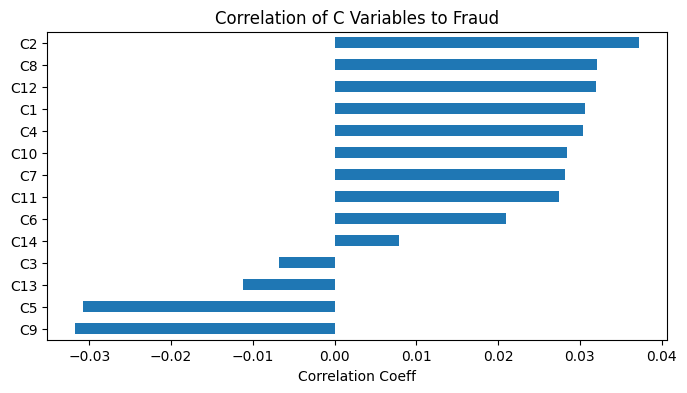

In [19]:
# C variables are masked counting variables

c_corr = transactions[[f'C{i}' for i in range(1, 15)] + ['isFraud']].corr()['isFraud'].sort_values()

plt.figure(figsize=(8,4))
c_corr.drop('isFraud').plot(kind='barh')
plt.title('Correlation of C Variables to Fraud')
plt.xlabel('Correlation Coeff')
plt.show()

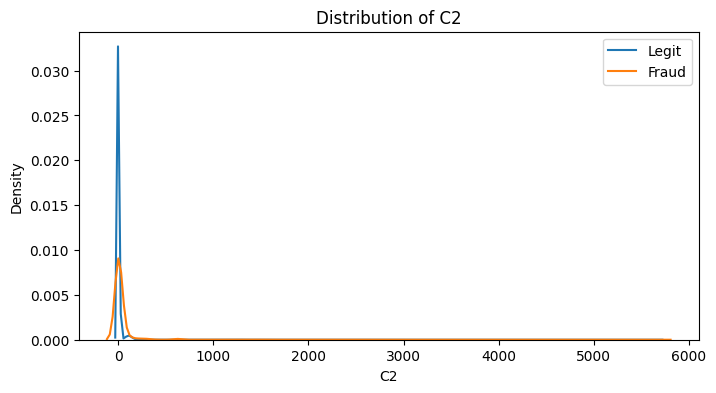

In [20]:
# Finding column with highest corr with fraud, else assume that it's C1
strongest_c = c_corr.drop('isFraud').idxmax()
if pd.isna(strongest_c): strongest_c = 'C1'

# We can see tha C2 fraud has a longer tail than C2 legit
plt.figure(figsize=(8,4))
sns.kdeplot(data = transactions[transactions['isFraud'] == 0], x=strongest_c, label='Legit')
sns.kdeplot(data = transactions[transactions['isFraud'] == 1], x=strongest_c, label='Fraud')
plt.title(f'Distribution of {strongest_c}')
plt.legend()
plt.show()

In [21]:
counter = 1000

print(f'Non-Fraud Transactions of C2 greater than {counter}: ', transactions[(transactions['C2'] >= counter) & (transactions['isFraud'] == 0)].shape[0])
print(f'Fraud Transactions of C2 greater than {counter}: ', transactions[(transactions['C2'] >= counter) & (transactions['isFraud'] == 1)].shape[0])

Non-Fraud Transactions of C2 greater than 1000:  1631
Fraud Transactions of C2 greater than 1000:  199


## D Variables (timedelta)

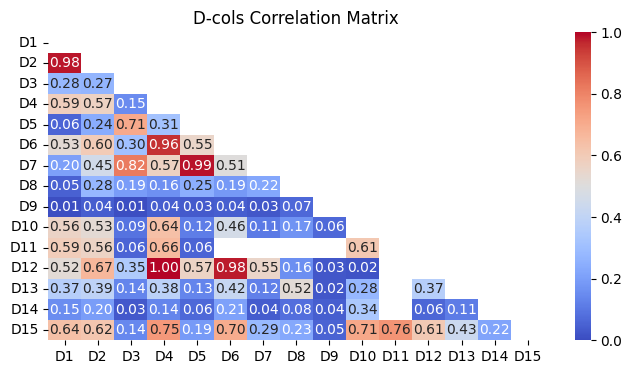

In [22]:
# Identifying correlations to reduce noise
# Pairs: D1 & D2, D4 & D6, D5 & D7, D4 & D12, D6 & D12

d_cols = [f'D{i}' for i in range(1, 16)]

plt.figure(figsize=(8,4))
corr_matrix = transactions[d_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', vmin=0, vmax=1)
plt.title('D-cols Correlation Matrix')
plt.show()

/tmp/ipykernel_5994/458367146.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transactions['time_bin'] = pd.cut(transactions[col], bins=bins, labels=labels)


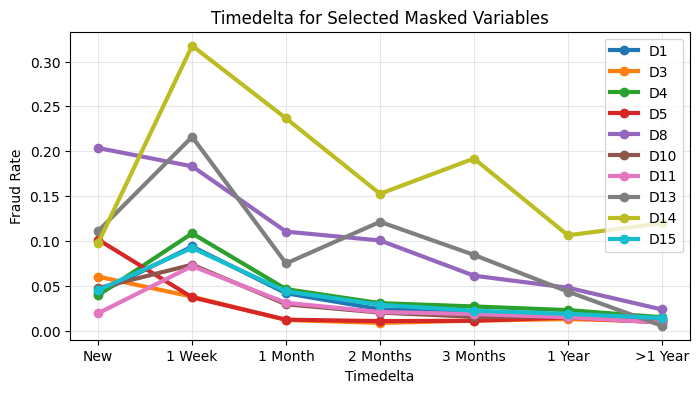

In [23]:
def get_risk_trends(col):
    bins = [-1, 0, 7, 30, 60, 90, 365, 9999]
    labels = ['New', '1 Week', '1 Month', '2 Months', '3 Months', '1 Year', '>1 Year']

    transactions['time_bin'] = pd.cut(transactions[col], bins=bins, labels=labels)
    return transactions.groupby('time_bin')['isFraud'].mean()

# Let's select the timedelta variables without strong correlations
target_ds = ['D1', 'D3', 'D4', 'D5', 'D8', 'D10', 'D11', 'D13', 'D14', 'D15']

# Fraud rate for most D variables are going down as accounts age
# New accounts are most dangerous
# But D8, D13 and D14 are high-risk despite account age
plt.figure(figsize=(8,4))
for col in target_ds:
    risk_curve = get_risk_trends(col)
    plt.plot(risk_curve.index, risk_curve.values, marker='o', linewidth=3, label=col)
plt.title('Timedelta for Selected Masked Variables')
plt.ylabel('Fraud Rate')
plt.xlabel('Timedelta')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## M Variables (match)

In [24]:
# Mostly boolean and null values
transactions[[f'M{i}' for i in range(1, 10)]]

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
590535,T,T,T,M0,T,F,F,F,T
590536,T,F,F,M0,F,T,F,F,F
590537,T,F,F,NaN,NaN,T,NaN,NaN,NaN
590538,T,T,T,M0,F,T,NaN,NaN,NaN


In [25]:
for i in range(1, 10):
    col = f'M{i}'
    print(f"--- {col} Distribution ---")
    print(transactions[col].value_counts(dropna=False, normalize=True)) 
    print("\n")

--- M1 Distribution ---
M1
T      0.540886
NaN    0.459071
F      0.000042
Name: proportion, dtype: float64


--- M2 Distribution ---
M2
T      0.483402
NaN    0.459071
F      0.057527
Name: proportion, dtype: float64


--- M3 Distribution ---
M3
NaN    0.459071
T      0.426273
F      0.114656
Name: proportion, dtype: float64


--- M4 Distribution ---
M4
NaN    0.476588
M0     0.332585
M2     0.101373
M1     0.089454
Name: proportion, dtype: float64


--- M5 Distribution ---
M5
NaN    0.593494
F      0.224356
T      0.182150
Name: proportion, dtype: float64


--- M6 Distribution ---
M6
F      0.385843
T      0.327368
NaN    0.286788
Name: proportion, dtype: float64


--- M7 Distribution ---
M7
NaN    0.586353
F      0.357933
T      0.055713
Name: proportion, dtype: float64


--- M8 Distribution ---
M8
NaN    0.586331
F      0.262897
T      0.150772
Name: proportion, dtype: float64


--- M9 Distribution ---
M9
NaN    0.586331
T      0.348251
F      0.065418
Name: proportion, dtype: floa

In [26]:
boolean_cols = ['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']
boolean_map = {'T': 1, 'F': 0}

for col in boolean_cols:
    transactions[col] = transactions[col].map(boolean_map)

# Mapping M4 differently because it has odd values
m4_map = {'M0': 0, 'M1': 1, 'M2': 2}
transactions['M4'] = transactions['M4'].map(m4_map)

m_cols = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
transactions[m_cols] = transactions[m_cols].fillna(-1)

print(transactions[m_cols].head())

    M1   M2   M3   M4   M5   M6   M7   M8   M9
0  1.0  1.0  1.0  2.0  0.0  1.0 -1.0 -1.0 -1.0
1 -1.0 -1.0 -1.0  0.0  1.0  1.0 -1.0 -1.0 -1.0
2  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
3 -1.0 -1.0 -1.0  0.0  1.0  0.0 -1.0 -1.0 -1.0
4 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0


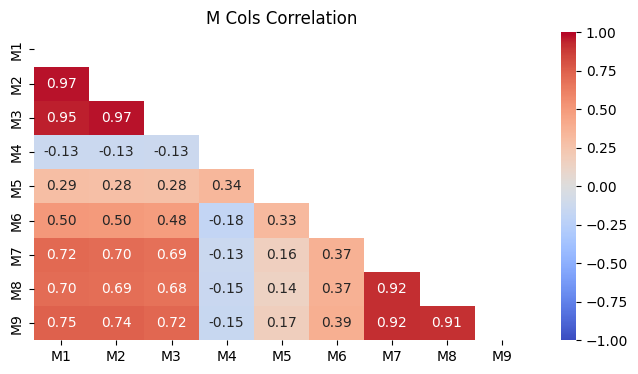

High Corr Pairs (>0.75)
M2 <--> M1 : 0.97
M3 <--> M1 : 0.95
M3 <--> M2 : 0.97
M8 <--> M7 : 0.92
M9 <--> M7 : 0.92
M9 <--> M8 : 0.91


In [27]:
df_m = transactions[['isFraud'] + [f'M{i}' for i in range(1, 10)]].copy()

corr_matrix = df_m.drop('isFraud', axis=1).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(8,4))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('M Cols Correlation')
plt.show()

# M1, M4, M5, M6, and M7 are good. The others are noise for a model
print('High Corr Pairs (>0.75)')
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        score = corr_matrix.iloc[i, j]
        if abs(score) > 0.75:
            col_1 = corr_matrix.columns[i]
            col_2 = corr_matrix.columns[j]
            high_corr_pairs.append((col_1, col_2, score))
            print(f'{col_1} <--> {col_2} : {score:.2f}')

## V variables (engineered, masked)